In [1]:
!git clone https://github.com/yeeyangtee/private-data-generation.git

Cloning into 'private-data-generation'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 103 (delta 35), reused 84 (delta 20), pack-reused 0
Receiving objects: 100% (103/103), 1.21 MiB | 3.93 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
cd /content/private-data-generation

/content/private-data-generation


In [3]:
# Download datasets
!gdown --id 1PaXMlTVHoB-vv-CaY1SgZDhf3evZjWf9 # churn processed
!gdown --id 1sJRwaeYcNaX_hqRJdhqAtMWnX7h-XKJE # marketing processed

Downloading...
From: https://drive.google.com/uc?id=1PaXMlTVHoB-vv-CaY1SgZDhf3evZjWf9
To: /content/private-data-generation/churn_processed.csv
100% 443k/443k [00:00<00:00, 3.26MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sJRwaeYcNaX_hqRJdhqAtMWnX7h-XKJE
To: /content/private-data-generation/marketing_processed.csv
100% 224k/224k [00:00<00:00, 2.02MB/s]


## Full PATEGAN rewrite

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from models import dp_wgan, pate_gan
import numpy as np
import pandas as pd
import collections, time

In [5]:
# HYPERPARAMETERS
MODEL_NAME = 'PATEGAN' # Don't change this
DATASET_NAME = 'churn' # Choose either 'churn' or 'marketing' exactly!
TARGET_VARIABLE = 'Exited' # either 'Exited' or 'Response'
TRAIN_TEST_RATIO = 0.25
LEAKY = False # Put False for normal relu. The number indicates the amount of negative slope. Default is 0.01

# These seem to be good to tune from what I can tell from the github.
NUM_TEACHERS = 2
TARGET_EPSILON = 1
TARGET_DELTA = 1e-4
LEARNING_RATE = 1e-4

# Following defaults in the toolbox. Might not be crucial to tune these
BATCH_SIZE = 64
TEACHER_ITER = 5
STUDENT_ITER = 5
NUM_MOMENTS= 100
LAP_SCALE = 1e-4

In [6]:
# Read in data and do train test split
df = pd.read_csv(f'{DATASET_NAME}_processed.csv')
df_train, df_test = train_test_split(df, test_size=TRAIN_TEST_RATIO, random_state=42, stratify = df[TARGET_VARIABLE])

# Initialise logfile path
timestamp = int(time.time())
logfile = f'log_{DATASET_NAME}_{MODEL_NAME}_{timestamp}_{TARGET_EPSILON}.csv'

In [7]:
# Grab x and y from the respective dataframes and convert to numpy arrays.
train_x = df_train.drop(columns=TARGET_VARIABLE).values
train_y = df_train[TARGET_VARIABLE].values
test_x = df_test.drop(columns=TARGET_VARIABLE).values
test_y = df_test[TARGET_VARIABLE].values

# Initialise scaler and use this to normalize the inputs.
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)


# Some misc variables for pategan 
data_columns = [col for col in df_train.columns if col != TARGET_VARIABLE]
class_ratios = df_train[TARGET_VARIABLE].sort_values().groupby(df_train[TARGET_VARIABLE]).size().values/train_x.shape[0]
input_dim = train_x.shape[1]
z_dim = int(input_dim / 4 + 1) if input_dim % 4 == 0 else int(input_dim / 4)
conditional = True

In [8]:
# Initialise hyperparams and do TRAINING
Hyperparams = collections.namedtuple(
        'Hyperarams',
        'batch_size num_teacher_iters num_student_iters num_moments lap_scale class_ratios lr')
Hyperparams.__new__.__defaults__ = (None, None, None, None, None, None, None)

model = pate_gan.PATE_GAN(LEAKY,logfile, input_dim, z_dim, NUM_TEACHERS, TARGET_EPSILON, TARGET_DELTA, conditional)
model.train(train_x, train_y, Hyperparams(batch_size=BATCH_SIZE, num_teacher_iters=TEACHER_ITER,
                                              num_student_iters=STUDENT_ITER, num_moments=NUM_MOMENTS,
                                              lap_scale=LAP_SCALE, class_ratios=class_ratios, lr=LEARNING_RATE))


Step :  0 Loss SD :  0.695025455129435 Loss G :  0.6525820669627509 Epsilon :  0.09274980371976183
Step :  100 Loss SD :  0.6977739533075453 Loss G :  0.6569632987137833 Epsilon :  0.1573898037197612
Step :  200 Loss SD :  0.6961526821152115 Loss G :  0.6623422477014315 Epsilon :  0.21898734555266197
Step :  300 Loss SD :  0.6889273819249875 Loss G :  0.6649504395218064 Epsilon :  0.2683311937967585
Step :  400 Loss SD :  0.6967714245450976 Loss G :  0.6740687070261588 Epsilon :  0.31005607286626513
Step :  500 Loss SD :  0.6874122205946438 Loss G :  0.6758334808714939 Epsilon :  0.34691385874029596
Step :  600 Loss SD :  0.6947179864601305 Loss G :  0.6782044956944618 Epsilon :  0.38028613004031625
Step :  700 Loss SD :  0.6929923614351505 Loss G :  0.6842680033346 Epsilon :  0.41104863048834817
Step :  800 Loss SD :  0.6915184401909658 Loss G :  0.691501737142534 Epsilon :  0.4397290183803887
Step :  900 Loss SD :  0.6923813823039746 Loss G :  0.6901109145308744 Epsilon :  0.46668090

In [9]:
# Optional: Look at model architectures
print(model.student_disc)
print(model.teacher_disc[0])
print(model.generator)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=14, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=14, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=13, bias=True)
  )
)


## Generate synthetic data using trained model, then save in CSV

In [27]:
# Helper functions for saving the synthetic data...
def update_array(indexes, cols = None):
    if cols: colsize = cols
    else: colsize = indexes.max() +1
    b = np.zeros((indexes.size, colsize))
    b[np.arange(indexes.size), indexes] = 1
    return b

def save_marketing():
    # Some fancy indexing to get the actual synthetic data..
    accepted = np.argmax(syn_save[:,16:21], axis=1)
    education = np.argmax(syn_save[:, 22:27], axis=1)
    marital = np.argmax(syn_save[:, 27:34], axis=1)
    country = np.argmax(syn_save[:, 34:], axis=1)

    syn_save[:,16:21] = update_array(accepted, cols=5)
    syn_save[:, 22:27] = update_array(education, cols=5)
    syn_save[:, 27:34] = update_array(marital, cols=7)
    syn_save[:, 34:] = update_array(country, cols=8)

    df1 = pd.DataFrame(syn_save, columns = df.columns.drop(TARGET_VARIABLE))
    df2 = pd.DataFrame(syn_y, columns = [TARGET_VARIABLE])
    df_save = pd.concat([df1,df2], axis =1)
    df_save.to_csv(f'synthetic_{MODEL_NAME}_{DATASET_NAME}_{TARGET_EPSILON}.csv')

def save_churn():
    geography = np.argmax(syn_save[:,8:11], axis=1)
    gender = np.argmax(syn_save[:,11:], axis=1)
    
    syn_save[:,8:11] = update_array(geography, cols=3)
    syn_save[:, 11:] = update_array(gender, cols=2)
    syn_save[:,4] = np.round(syn_save[:,4]) # num products
    syn_save[:,5] = np.round(np.clip(syn_save[:,5],0,1)) # Has card
    syn_save[:,6] = np.round(np.clip(syn_save[:,6],0,1)) # Is active


    df1 = pd.DataFrame(syn_save, columns = df.columns.drop(TARGET_VARIABLE))
    df2 = pd.DataFrame(syn_y, columns = [TARGET_VARIABLE])
    df_save = pd.concat([df1,df2], axis =1)
    df_save.to_csv(f'synthetic_{MODEL_NAME}_{DATASET_NAME}_{TARGET_EPSILON}.csv')
    return df_save


In [26]:
np.round(np.clip(syn_save[:,5],0,1)).min()

0.0

In [28]:
df_save = save_churn()

In [37]:
df_save

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,569.189810,40.029415,6.717890,89681.936477,2.0,1.0,1.0,130466.340459,0.0,0.0,1.0,0.0,1.0,0.0
1,570.501744,33.474992,8.674211,110469.707352,1.0,1.0,1.0,71928.116744,1.0,0.0,0.0,0.0,1.0,0.0
2,419.490332,51.890009,18.356562,200372.129774,0.0,0.0,1.0,264136.140441,0.0,0.0,1.0,0.0,1.0,1.0
3,542.538826,42.563155,8.338049,117159.416072,1.0,0.0,1.0,155246.459858,0.0,0.0,1.0,0.0,1.0,0.0
4,577.241597,42.062559,10.930599,89837.667759,1.0,0.0,1.0,137180.080401,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,594.765712,36.708907,6.737492,84549.090124,1.0,1.0,1.0,88441.888815,1.0,0.0,0.0,0.0,1.0,0.0
7496,533.535706,43.156655,10.432683,119125.835245,1.0,0.0,1.0,163115.984498,0.0,0.0,1.0,0.0,1.0,0.0
7497,563.589866,39.947245,6.797705,91301.876516,2.0,1.0,1.0,132893.947639,0.0,0.0,1.0,0.0,1.0,0.0
7498,586.354935,38.140655,8.512222,92579.078628,1.0,1.0,1.0,102529.715082,1.0,0.0,0.0,0.0,1.0,0.0


In [15]:
df_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [50]:
COL = 5
print(df_train.iloc[:,COL].value_counts())
print(df_save.iloc[:,COL].value_counts())

1    5304
0    2196
Name: HasCrCard, dtype: int64
0.0    5547
1.0    1953
Name: HasCrCard, dtype: int64


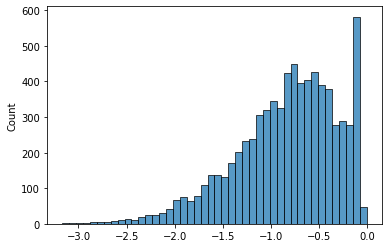

In [51]:
import seaborn as sns

sns.histplot(syn_x[:,COL])

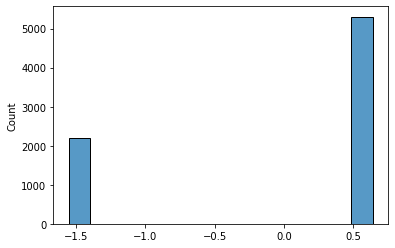

In [52]:
sns.histplot(train_x[:,COL])

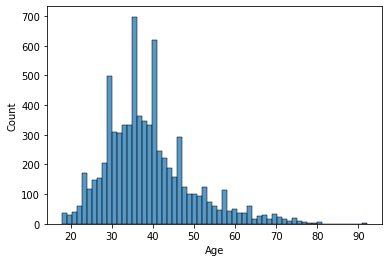

In [19]:
sns.histplot(df_train['Age'])

In [13]:
# Run this cell to generate data and save them.
syn_data = model.generate(train_x.shape[0], class_ratios)
syn_x, syn_y = syn_data[:, :-1], syn_data[:, -1]

# Make a copy for saving
syn_save = scaler.inverse_transform(syn_x)

# Save data to csv using functions
if DATASET_NAME == 'churn': save_churn()
else: save_marketing()

## Do classification using Neural Networks and look at ROC Score

In [41]:
# Train using Synthetic data, using simple neural network.
mlp = MLPClassifier((32,8), max_iter=1000, random_state=42)
mlp.fit(syn_x, syn_y)
pred_y = mlp.predict(test_x)

print('ROC Score', roc_auc_score(test_y, pred_y))
print('Accuracy', mlp.score(test_x,test_y))

ROC Score 0.523977249291754
Accuracy 0.4852


In [42]:
# Train using REAL data, using simple neural network.
mlp = MLPClassifier((32,8), max_iter=1000, random_state=42)
mlp.fit(train_x, train_y)
pred_y = mlp.predict(test_x)

print('ROC Score', roc_auc_score(test_y, pred_y))
print('Accuracy', mlp.score(test_x,test_y))
# Uitvoer van uitgevoerde code vanaf 7 jun. 2021 03:50
# 	Stream
# 		ROC Score 0.7530632082470008
# 		Accuracy 0.8754512635379061

ROC Score 0.7328967583990432
Accuracy 0.8564


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
# Initialise all models
classifier_names = ['MLP', 'RF', 'ADABOOST', 'DT', 'GauNB', 'BernNB', 'SVM', 'LogReg']
classifiers = [MLPClassifier((32,8), max_iter=1000, random_state=42), #MLP
               RandomForestClassifier(max_depth=2, random_state=42), #RF
               AdaBoostClassifier(n_estimators=50, random_state=42),
               DecisionTreeClassifier(random_state=42),
               GaussianNB(),
               BernoulliNB(),
               SVC(random_state=42),
               LogisticRegression(random_state=42)
]

In [ ]:
syn_clf_accuracy = []
syn_clf_roc_score = []
real_clf_accuracy = []
real_clf_roc_score = []

# Loop thru all classifiers.
for clf in classifiers:

    # Do synthetic
    clf.fit(syn_x, syn_y)
    pred_y = clf.predict(test_x)

    # compute score and append
    syn_clf_roc_score.append(roc_auc_score(test_y, pred_y))
    syn_clf_accuracy.append(clf.score(test_x,test_y))

    # Do real training data
    clf.fit(train_x, train_y)
    pred_y = clf.predict(test_x)

    # compute score and append
    real_clf_roc_score.append(roc_auc_score(test_y, pred_y))
    real_clf_accuracy.append(clf.score(test_x,test_y))

In [ ]:
score_df = pd.DataFrame({'Classifier Name':classifier_names,
                         'Accuracy on Synthetic':syn_clf_accuracy,
                         'ROC on Synthetic': syn_clf_roc_score,
                         'Accuracy on Real': real_clf_accuracy,
                         'ROC on Real': real_clf_roc_score,
                         })
score_df.to_csv('scores.csv') # Make into a csv that you can download and do computations!

In [ ]:
score_df

,Classifier Name,Accuracy on Synthetic,ROC on Synthetic,Accuracy on Real,ROC on Real
0,MLP,0.518051,0.612347,0.875451,0.753063
1,RF,0.850181,0.500000,0.851986,0.506024
2,ADABOOST,0.750903,0.545827,0.897112,0.750914
3,DT,0.514440,0.550674,0.803249,0.656013
4,GauNB,0.738267,0.622759,0.871841,0.636802
5,BernNB,0.790614,0.519556,0.781588,0.702824
6,SVM,0.850181,0.500000,0.879061,0.626161
7,LogReg,0.723827,0.658929,0.895307,0.715115
